In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.1
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
# unzip it
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
# install findspark 
!pip install -q findspark

# environmental variable of java and spark was set
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

import findspark
findspark.init()

In [2]:
# Spark session

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Heart_Disease_Prediction').getOrCreate()

In [3]:
# For plotting
import matplotlib.pyplot as plt

# Feature extraction
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

# Classification models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier

# Classification evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Importing function
import pyspark.sql.functions as f

In [4]:
# Importing files from local disk

from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank (1).csv


In [5]:
# Bank Marketing dataset

dataset = spark.read.csv("bank.csv", inferSchema = True, header = True)
dataset.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [6]:
print((dataset.count(), len(dataset.columns)))

(11162, 17)


In [7]:
dataset.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [8]:
dataset.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

In [9]:
dataset.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [10]:
my_data = dataset.drop(*['contact', 'day', 'month', 'default'])
my_data.show()

+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|balance|housing|loan|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|   2343|    yes|  no|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     45|     no|  no|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|   1270|    yes|  no|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|   2476|    yes|  no|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|    184|     no|  no|     673|       2|   -1|       0| unknown|    yes|
| 42| management|  single| tertiary|      0|    yes| yes|     562|       2|   -1|       0| unknown|    yes|
| 56| management| married| t

In [11]:
my_data.describe().show()

+-------+------------------+-------+--------+---------+------------------+-------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|           balance|housing| loan|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+------------------+-------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|             11162|  11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|1528.5385235620856|   null| null|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|    null|   null|
| stddev|11.913369192215518|   null|    null|     null| 3225.413325946149|   null| null|34

**To know whether there is any null value or not.**

In [12]:
data_agg = my_data.agg(*[f.count(f.when(f.isnull(col), col)).alias(col) for col in my_data.columns])
data_agg.show()

+---+---+-------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|balance|housing|loan|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|   0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+



**Some visualizations showing the relationship between job, duration and deposit.**

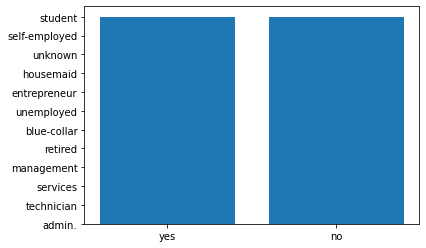

In [70]:
x_axis = my_data.toPandas()['deposit'].values.tolist()
y_axis = my_data.toPandas()['job'].values.tolist()

plt.bar(x_axis, y_axis)
plt.show()

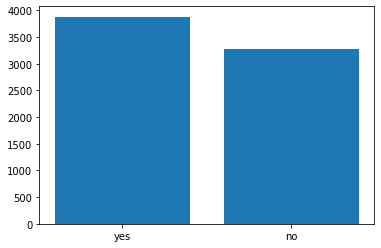

In [73]:
x_axis = my_data.toPandas()['deposit'].values.tolist()
y_axis = my_data.toPandas()['duration'].values.tolist()

plt.bar(x_axis, y_axis)
plt.show()

In [13]:
accept = ['job', 'marital', 'education', 'loan', 'poutcome', 'deposit']
for i in accept:
  print(my_data.groupBy(i).count().show())

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2566|
|      retired|  778|
|      unknown|   70|
|self-employed|  405|
|      student|  360|
|  blue-collar| 1944|
| entrepreneur|  328|
|       admin.| 1334|
|   technician| 1823|
|     services|  923|
|    housemaid|  274|
|   unemployed|  357|
+-------------+-----+

None
+--------+-----+
| marital|count|
+--------+-----+
|divorced| 1293|
| married| 6351|
|  single| 3518|
+--------+-----+

None
+---------+-----+
|education|count|
+---------+-----+
|  unknown|  497|
| tertiary| 3689|
|secondary| 5476|
|  primary| 1500|
+---------+-----+

None
+----+-----+
|loan|count|
+----+-----+
|  no| 9702|
| yes| 1460|
+----+-----+

None
+--------+-----+
|poutcome|count|
+--------+-----+
| success| 1071|
| unknown| 8326|
|   other|  537|
| failure| 1228|
+--------+-----+

None
+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+

None


In [14]:
my_data.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [15]:
categoricalColumns = [item[0] for item in my_data.dtypes if item[1].startswith('string')]
categoricalColumns

['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'deposit']

**String Indexer method.**

In [16]:
indexed = StringIndexer(inputCols = ['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'deposit'],
                        outputCols = ['job_index', 'marital_index', 'education_index', 'housing_index', 'loan_index', 'poutcome_index', 'deposit_index'])
my_data = indexed.fit(my_data).transform(my_data)
my_data.show()


+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+--------------+-------------+----------+-------------+-------------+---------------+---------+
|age|        job| marital|education|balance|housing|loan|duration|campaign|pdays|previous|poutcome|deposit|poutcome_index|deposit_index|loan_index|housing_index|marital_index|education_index|job_index|
+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+--------------+-------------+----------+-------------+-------------+---------------+---------+
| 59|     admin.| married|secondary|   2343|    yes|  no|    1042|       1|   -1|       0| unknown|    yes|           0.0|          1.0|       0.0|          1.0|          0.0|            0.0|      3.0|
| 56|     admin.| married|secondary|     45|     no|  no|    1467|       1|   -1|       0| unknown|    yes|           0.0|          1.0|       0.0|          0.0|          0.0|            0.0| 

In [17]:
my_data.select('job','job_index',
               'marital','marital_index',
               'education','education_index',
               'housing','housing_index',
               'loan','loan_index',
               'poutcome','poutcome_index',
               'deposit','deposit_index').show()

+-----------+---------+--------+-------------+---------+---------------+-------+-------------+----+----------+--------+--------------+-------+-------------+
|        job|job_index| marital|marital_index|education|education_index|housing|housing_index|loan|loan_index|poutcome|poutcome_index|deposit|deposit_index|
+-----------+---------+--------+-------------+---------+---------------+-------+-------------+----+----------+--------+--------------+-------+-------------+
|     admin.|      3.0| married|          0.0|secondary|            0.0|    yes|          1.0|  no|       0.0| unknown|           0.0|    yes|          1.0|
|     admin.|      3.0| married|          0.0|secondary|            0.0|     no|          0.0|  no|       0.0| unknown|           0.0|    yes|          1.0|
| technician|      2.0| married|          0.0|secondary|            0.0|    yes|          1.0|  no|       0.0| unknown|           0.0|    yes|          1.0|
|   services|      4.0| married|          0.0|secondary|  

**One Hot Encoder method.**

In [18]:
OHE = OneHotEncoder(inputCols = ['job_index', 'marital_index', 'education_index', 'housing_index', 'loan_index', 'poutcome_index', 'deposit_index'],
                    outputCols = ['job_ohe', 'marital_ohe', 'education_ohe', 'housing_ohe', 'loan_ohe', 'poutcome_ohe', 'deposit_ohe'])
my_data = OHE.fit(my_data).transform(my_data)

my_data.select('job', 'job_index', 'job_ohe',
               'marital','marital_index','marital_ohe',
               'education','education_index','education_ohe',
               'housing','housing_index','housing_ohe',
               'loan','loan_index','loan_ohe',
               'poutcome','poutcome_index','poutcome_ohe',
               'deposit','deposit_index','deposit_ohe').show()

+-----------+---------+--------------+--------+-------------+-------------+---------+---------------+-------------+-------+-------------+-------------+----+----------+-------------+--------+--------------+-------------+-------+-------------+-----------+
|        job|job_index|       job_ohe| marital|marital_index|  marital_ohe|education|education_index|education_ohe|housing|housing_index|  housing_ohe|loan|loan_index|     loan_ohe|poutcome|poutcome_index| poutcome_ohe|deposit|deposit_index|deposit_ohe|
+-----------+---------+--------------+--------+-------------+-------------+---------+---------------+-------------+-------+-------------+-------------+----+----------+-------------+--------+--------------+-------------+-------+-------------+-----------+
|     admin.|      3.0|(11,[3],[1.0])| married|          0.0|(2,[0],[1.0])|secondary|            0.0|(3,[0],[1.0])|    yes|          1.0|    (1,[],[])|  no|       0.0|(1,[0],[1.0])| unknown|           0.0|(3,[0],[1.0])|    yes|          1

**Final my_data dataset after all conversion.**

In [19]:
my_data.show()

+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+--------------+-------------+----------+-------------+-------------+---------------+---------+-------------+-----------+-------------+-------------+-------------+-------------+--------------+
|age|        job| marital|education|balance|housing|loan|duration|campaign|pdays|previous|poutcome|deposit|poutcome_index|deposit_index|loan_index|housing_index|marital_index|education_index|job_index|education_ohe|deposit_ohe| poutcome_ohe|  housing_ohe|  marital_ohe|     loan_ohe|       job_ohe|
+---+-----------+--------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+--------------+-------------+----------+-------------+-------------+---------------+---------+-------------+-----------+-------------+-------------+-------------+-------------+--------------+
| 59|     admin.| married|secondary|   2343|    yes|  no|    1042|       1|   -1|       0| unknown|    

In [20]:
my_data.columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit',
 'poutcome_index',
 'deposit_index',
 'loan_index',
 'housing_index',
 'marital_index',
 'education_index',
 'job_index',
 'education_ohe',
 'deposit_ohe',
 'poutcome_ohe',
 'housing_ohe',
 'marital_ohe',
 'loan_ohe',
 'job_ohe']

**All the features in the original dataset was assembled into a vector named "features".**

In [22]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['age',
                                        'balance',
                                        'duration',
                                        'campaign',
                                        'pdays',
                                        'previous',
                                        'poutcome_index',
                                        'loan_index',
                                        'housing_index',
                                        'marital_index',
                                        'education_index',
                                        'job_index',
                                        'education_ohe',
                                        'poutcome_ohe',
                                        'housing_ohe',
                                        'marital_ohe',
                                        'loan_ohe',
                                        'job_ohe'],
                            outputCol = 'features')

my_data = my_data.fillna(0)

final_data = assembler.transform(my_data)

In [23]:
final_data.select('features', 'deposit_index').show()

+--------------------+-------------+
|            features|deposit_index|
+--------------------+-------------+
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,11...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,10...|          1.0|
|(33,[0,2,3,4,7,8,...|          1.0|
|(33,[0,1,2,3,4,7,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,7,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,8,...|          1.0|
|(33,[0,1,2,3,4,7,...|          1.0|
+--------------------+-------------+
only showing top 20 rows



**Model dataframe containing vectored features and label.**

In [24]:
model = final_data.select(['features', 'deposit_index'])
model = model.withColumnRenamed("deposit_index", "label")
model.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [74]:
model.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,11...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,10...|  1.0|
|(33,[0,2,3,4,7,8,...|  1.0|
|(33,[0,1,2,3,4,7,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,7,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,8,...|  1.0|
|(33,[0,1,2,3,4,7,...|  1.0|
+--------------------+-----+
only showing top 20 rows



**Splitting of the dataset into train_data and test_data in th ration of 3:1.**

In [26]:
train_data, test_data = model.randomSplit([0.75, 0.25], seed = 42)

print("This is the Train dataset:- ")
print(train_data.show())

print("This is the Test dataset:- ")
print(test_data.show())

This is the Train dataset:- 
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  0.0|
+--------------------+-----+
only showing top 20 rows

None
This is the Test dataset:- 
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  0.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3,4,5,...|  1.0|
|(33,[0,1,2,3

**Logistic Regression Model**

In [75]:
logistic = LogisticRegression().fit(train_data)

logistic_summary = logistic.summary

In [57]:
predictions_lr = logistic.transform(test_data)

predictions_lr.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [60]:
print("Logistic Regression Accuracy = ", logistic_summary.accuracy*100)
print("Logistic Regression Test Error = %g " % (1.0 - logistic_summary.accuracy))
print("Logistic Regression ROC = ", logistic_summary.areaUnderROC*100)

Logistic Regression Accuracy =  79.84091178914876
Logistic Regression Test Error = 0.201591 
Logistic Regression ROC =  87.97282090276762


In [47]:
print("For Precision")
print("YES: ", logistic_summary.precisionByLabel[1])
print("NO: ", logistic_summary.precisionByLabel[0])

print("For Recall")
print("YES: ", logistic_summary.recallByLabel[1])
print("NO: ", logistic_summary.recallByLabel[0])


For Precision
YES:  0.813451425408248
NO:  0.7871101871101871
For Recall
YES:  0.7416098914963412
NO:  0.8488789237668162


**Decision Tree Classifier Model.**

In [37]:
dtc = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dtc = dtc.fit(train_data)

predictions = dtc.transform(test_data)
predictions.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  0.0|       1.0|
|  1.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [58]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Decision Tree Classifier Test Error = %g " % (1.0 - accuracy))
print("Decision Tree Classifier Accuracy = %g " % accuracy)

Decision Tree Classifier Test Error = 0.204819 
Decision Tree Classifier Accuracy = 0.795181 
